In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from server import Server
import matplotlib.pyplot as plt

In [4]:
server = Server(max_req=10000, arrival_rate=80/1000)
history_num_job_arrived, history_num_job_served, buffer_t1, buffer_t2 \
= server.run()

In [ ]:
history_num_job_arrived

In [ ]:
history_num_job_served

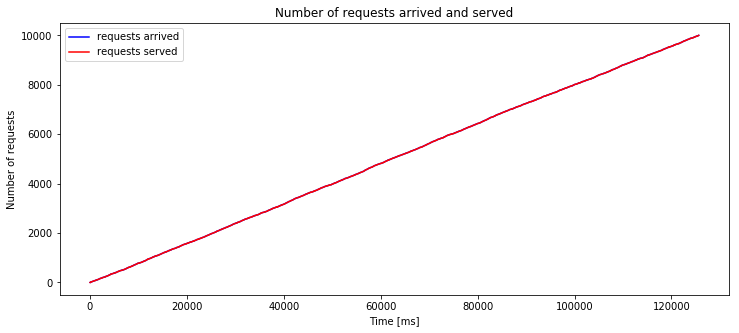

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

x0, y0 = list(zip(*history_num_job_arrived))
x1, y1 = list(zip(*history_num_job_served))

ax.step(x0, y0, c='b', label='requests arrived')
ax.step(x1, y1, c='r', label='requests served')
ax.set_title('Number of requests arrived and served')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Number of requests')
plt.legend()
plt.savefig('q1_req.png', dpi=300)

In [ ]:
buffer_t1

In [ ]:
buffer_t2

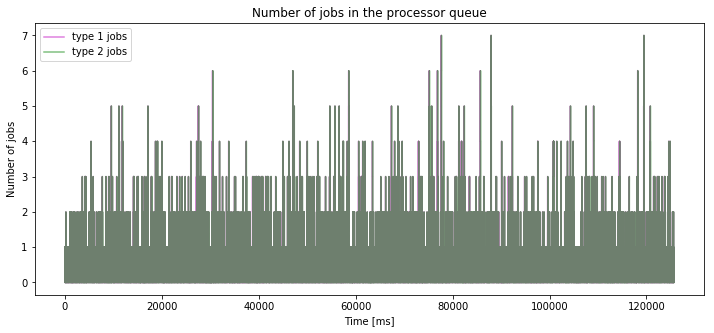

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

x0, y0 = list(zip(*buffer_t1))
x1, y1 = list(zip(*buffer_t2))

ax.step(x0, y0, c='m', label='type 1 jobs', alpha=0.5)
ax.step(x1, y1, c='g', label='type 2 jobs', alpha=0.5)
ax.set_title('Number of jobs in the processor queue')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Number of jobs')
plt.legend()
plt.savefig('q1_job.png', dpi=300)